# Neural Network: DenseNet169

## Import the required libraries and packages

In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.9:
  Successfully uninstalled kaggle-1.5.9
     |████████████████████████████████| 1.5MB 13.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 5.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=6bb0a4eccc1d1d84fcf734b7c3b93176f5df0ac079a69d2f7b52a4228c726c88
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection -p /content/

100% 6.31G/6.31G [02:18<00:00, 25.0MB/s]
100% 6.31G/6.31G [02:18<00:00, 49.0MB/s]


In [5]:
%cd /content
!ls

/content
adc.json  histopathologic-cancer-detection.zip	sample_data


In [6]:
!mkdir /content/histopathologic
!unzip -qq /content/histopathologic-cancer-detection.zip -d /content/histopathologic

In [7]:
!ls

adc.json  histopathologic  histopathologic-cancer-detection.zip  sample_data


In [8]:
import numpy as np
import pandas as pd

#import gc
import os
import pprint
import itertools
from tqdm import tqdm
from glob import glob
from random import shuffle
import cv2
import datetime
import matplotlib.pyplot as plt

import albumentations as A
#from albumentations import Compose, RandomRotate90, Transpose, Flip, OneOf, CLAHE, IAASharpen, IAAEmboss, RandomBrightnessContrast, JpegCompression, Blur, GaussNoise, HueSaturationValue, ShiftScaleRotate, Normalize

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils, DenseNet169

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Load the datasets

In [9]:
TRAIN_IMAGES_PATH = "/content/histopathologic/train"
TEST_IMAGES_PATH = "/content/histopathologic/test"

In [10]:
df_train = pd.read_csv("/content/histopathologic/train_labels.csv")

df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [11]:
bad_images = [
    '9071b424ec2e84deeb59b54d2450a6d0172cf701', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', 
    '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '54df3640d17119486e5c5f98019d2a92736feabc', 
    '5a268c0241b8510465cb002c4452d63fec71028a', 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83',
    '9369c7278ec8bcc6c880d99194de09fc2bd4efbe'
]

In [12]:
# Drop indexes of the bad images off df_train
idxs_to_use = np.where(~df_train['id'].isin(bad_images))

df_train = df_train.iloc[idxs_to_use]

In [13]:
val_size, test_size = round(df_train.shape[0]/10), round(df_train.shape[0]/10)

train, test = train_test_split(df_train, test_size=test_size, random_state=42)

train, val = train_test_split(train, test_size=val_size, random_state=42)

In [14]:
print(train.shape)
print(val.shape)
print(test.shape)

(176014, 2)
(22002, 2)
(22002, 2)


## Data Generator

In [15]:
class Generator:
    def __init__(self, imagePath, dataFrame, batchSize, aug=None, binarize=True, n_classes=2):
        #store the variables
        self.imagePath = imagePath
        self.dataFrame = dataFrame
        self.batchSize = batchSize
        self.aug = aug
        self.binarize = binarize
        self.n_classes = n_classes
        
        self.numImages = self.dataFrame['label'].shape[0]
        
    def generator(self, passes=np.inf):
        
        epochs = 0
        
        #loop infinitely; the model will stop when the desired epoch is reached
        while epochs < passes:
            #loop over and generate images in batches
            for i in np.arange(0, self.numImages, self.batchSize):
                image_ids = self.dataFrame['id'][i : i + self.batchSize]
                labels = self.dataFrame['label'][i : i + self.batchSize]
                
                #read the images
                images_array = []
                for image_id in image_ids:
                    image = cv2.imread(os.path.sep.join([self.imagePath, image_id]) + '.tif')
                    b, g, r = cv2.split(image)
                    image = cv2.merge([r, g, b])
                    images_array.append(image)
                    
                images = np.array(images_array)
                
                #check whether or not the labels should be binarized
                if self.binarize:
                    labels = to_categorical(labels, self.n_classes)
                    
                #if data augmentation is to be applied
                if self.aug is not None:
                    images = np.stack([self.aug(image=image)['image'] for image in images], axis=0)
                    
                yield images, np.array(labels)
                
            epochs += 1

## Data Augmentation

In [16]:
def do_augmentations():
    return A.Compose([
        A.RandomRotate90(p=0.7),
        A.OneOf([
            A.HorizontalFlip(p=1), 
            A.VerticalFlip(p=1)]
        ),
        A.RandomBrightness(limit=0.07, p=0.5),
        A.RandomContrast(limit=0.07, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0,
                    always_apply=False,
                    p=1.0
                   )
    ])

## Build the Neural Network

In [17]:
def get_model(img_size):
    
    base_model = DenseNet169(
        weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    
    x1 = GlobalMaxPooling2D()(base_model.output)    # Compute the max pooling of the base model output
    x2 = GlobalAveragePooling2D()(base_model.output)    # Compute the average pooling of the base model output  
    x3 = Flatten()(base_model.output)    # Flatten the base model output

    x = Concatenate(axis=-1)([x1, x2, x3])
    x = Dropout(0.3)(x)
    
    # Add FC layers
    fc_layer_1 = Dense(512)(x)
    activation_1 = Activation('relu')(fc_layer_1)
    batch_norm_1 = BatchNormalization(axis=-1)(activation_1)
    dropout_1 = Dropout(0.5)(batch_norm_1)
    
    fc_layer_2 = Dense(256)(dropout_1)
    activation_2 = Activation('relu')(fc_layer_2)
    batch_norm_2 = BatchNormalization(axis=-1)(activation_2)
    dropout_2 = Dropout(0.5)(batch_norm_2)
    
    # Add the output layer
    output = Dense(2, activation='softmax')(dropout_2)
    
    # Create the model
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output)
    
    opt = tf.keras.optimizers.Adam(
        learning_rate=0.00007, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    )
    loss = tf.keras.losses.BinaryCrossentropy() 
    model.compile(optimizer=opt, loss=loss, metrics=[tf.keras.metrics.AUC(name='auc')])
    
    return model

## Store the hyperparameters

In [18]:
config = dict(
    IMAGE_SIZE=96,
    NUM_CLASSES=2,  # number of different classes in dataset
    LEARNING_RATE=0.00007,  # fixed learning rate
    TRAIN_BATCH_SIZE=32,
    VAL_BATCH_SIZE=32,
    TEST_BATCH_SIZE=16,
    #TRAIN_BATCH_SIZE=128*8,  # training batch size
    #VAL_BATCH_SIZE=128*8,  # validation batch size
    #TEST_BATCH_SIZE=32, # testing batch size
    TTA_STEPS=5,
    NUM_EPOCHS=15,  # number of epochs to train
    MODEL_PATH='/content/densenet169.h5'  # path to model checkpoint directory
)

In [19]:
# Construct a list of callbacks
callbacks = [
            TerminateOnNaN(),
            EarlyStopping(
                monitor='val_loss',
                patience=4,
                mode='min',
                verbose=1,
                restore_best_weights=True),
            ModelCheckpoint(
                config['MODEL_PATH'],
                monitor='val_loss',
                verbose=1,
                save_best_only=True,
                mode='min')]

In [20]:
# Define the dataset generators
trainGen = Generator(
    imagePath=TRAIN_IMAGES_PATH, dataFrame=train, batchSize=config['TRAIN_BATCH_SIZE'], 
    aug=do_augmentations(), binarize=True, n_classes=2
)

valGen = Generator(
    imagePath=TRAIN_IMAGES_PATH, dataFrame=val, batchSize=config['VAL_BATCH_SIZE'], 
    aug=do_augmentations(), binarize=True, n_classes=2
)

testGen = Generator(
    imagePath=TRAIN_IMAGES_PATH, dataFrame=test, batchSize=config['TEST_BATCH_SIZE'], 
    aug=do_augmentations(), binarize=True, n_classes=2
)

## Train the Neural Network

In [21]:
model = get_model(config['IMAGE_SIZE'])

model.summary()

51879936/51877672 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
______________________

In [ ]:
# Train the model
H = model.fit(
    trainGen.generator(), steps_per_epoch=trainGen.numImages//config['TRAIN_BATCH_SIZE'],
    validation_data=valGen.generator(), validation_steps=valGen.numImages//config['VAL_BATCH_SIZE'],
    epochs= config['NUM_EPOCHS'], verbose=1,
    callbacks = callbacks
)

Epoch 1/15
5500/5500 [==============================] - ETA: 0s - loss: 0.3009 - auc: 0.9515
Epoch 00001: val_loss improved from inf to 0.18336, saving model to /content/densenet169.h5
5500/5500 [==============================] - 618s 112ms/step - loss: 0.3009 - auc: 0.9515 - val_loss: 0.1834 - val_auc: 0.9794
Epoch 2/15
5500/5500 [==============================] - ETA: 0s - loss: 0.1723 - auc: 0.9810
Epoch 00002: val_loss improved from 0.18336 to 0.13206, saving model to /content/densenet169.h5
5500/5500 [==============================] - 622s 113ms/step - loss: 0.1723 - auc: 0.9810 - val_loss: 0.1321 - val_auc: 0.9882
Epoch 3/15
5500/5500 [==============================] - ETA: 0s - loss: 0.1388 - auc: 0.9871
Epoch 00003: val_loss improved from 0.13206 to 0.11792, saving model to /content/densenet169.h5
5500/5500 [==============================] - 621s 113ms/step - loss: 0.1388 - auc: 0.9871 - val_loss: 0.1179 - val_auc: 0.9905
Epoch 4/15
5500/5500 [==============================] - 

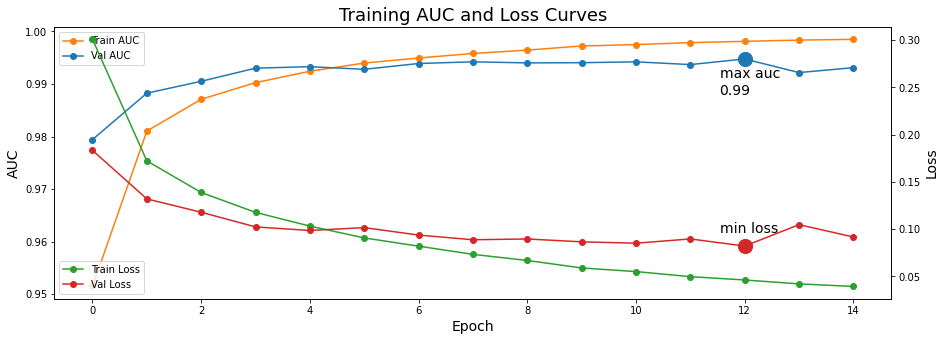

In [23]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(config['NUM_EPOCHS']),H.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
plt.plot(np.arange(config['NUM_EPOCHS']),H.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
x = np.argmax( H.history['val_auc'] ); y = np.max( H.history['val_auc'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
plt.legend(loc=2)
plt2 = plt.gca().twinx()
plt2.plot(np.arange(config['NUM_EPOCHS']),H.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(np.arange(config['NUM_EPOCHS']),H.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( H.history['val_loss'] ); y = np.min( H.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
plt.ylabel('Loss',size=14)
plt.title('Training AUC and Loss Curves',size=18)
plt.legend(loc=3)
plt.show()   

In [24]:
# Load the best model
model.load_weights(config['MODEL_PATH'])

## Predict on the test data

In [25]:
# Perform predictions on the test data using test-time augmentation
predictions_with_tta = []

for i in range(config['TTA_STEPS']):
    print('TTA step {}'.format(i+1))
    predictions = model.predict(
        testGen.generator(), steps=(testGen.numImages//config['TEST_BATCH_SIZE'])+1,
        max_queue_size=config['TEST_BATCH_SIZE']*2
    )
    predictions_with_tta.append(predictions)
    
predictions_with_tta = (np.array(predictions_with_tta).sum(axis=0)) / config['TTA_STEPS']

TTA step 1
TTA step 2
TTA step 3
TTA step 4
TTA step 5


In [26]:
cnf_matrix = confusion_matrix(test['label'], np.argmax(predictions_with_tta, axis=1))
tn, fn, tp, fp = cnf_matrix[0][0], cnf_matrix[1][0], cnf_matrix[1][1], cnf_matrix[0][1]

print('Sensitivity: {:.4f}'.format(tp/(tp+fn)))
print('Specificity: {:.4f}'.format(tn/(tn+fp)))
auc_score = roc_auc_score(test['label'], predictions_with_tta[:, 1])
print('AUC: {:.4f}'.format(auc_score))

Sensitivity: 0.9702
Specificity: 0.9796
AUC: 0.9957


In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[12749   265]
 [  268  8720]]


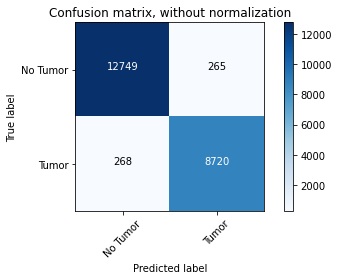

In [28]:
# Names of predicted classes
classes_names = ['No Tumor', 'Tumor']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes_names,
                      title='Confusion matrix, without normalization')

plt.show()

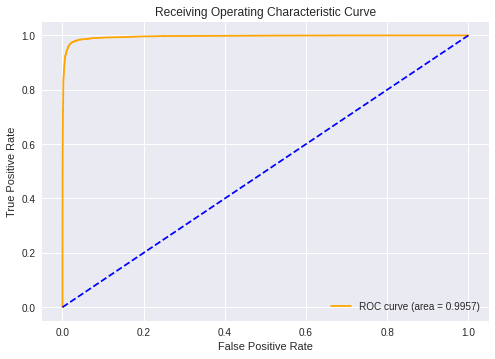

In [29]:
# Compute the ROC Curve
fpr, tpr, _ = roc_curve(test['label'], predictions_with_tta[:, 1], pos_label=1)

# Plot the ROC Curve
plt.style.use('seaborn')
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.title('Receiving Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [30]:
df = pd.DataFrame(dict(
    id=test['id'], 
    label=test['label'], 
    prediction=predictions_with_tta[:, 1]
))

df.to_csv('densenet169_preds.csv', index=False)